## Self Driving Car NanoDegree

### Advanced Lane Finding

### Calibrating Camera and Undistortion

In [197]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pandas as pd
import glob


In [198]:
# Read in calibration image
images = glob.glob('./camera_cal/calibration*.jpg') # reads in RGB

In [199]:
# Arrays to store object points and image points from all the images
objpoints = []
imgpoints = [] 

objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

for file in images:
    
    # Read in image
    img = mpimg.imread(file)
    
    # Convert to gray
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

    # if corners found, add object points and image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)

        # draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow()
        
        
        
# img = mpimg.imread(images[0])
# gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
# ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
# dst = cv2.undistort(img, mtx, dist, None, mtx)
# plt.imshow(dst)


In [200]:
def undistort(img, objpoints, imgpoints):
    # Use cv2.calibrateCamera() and cv2.undistort()
    gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1],None,None)
    undist = cv2.undistort(img, mtx, dist, None, mtx)
    return undist




True

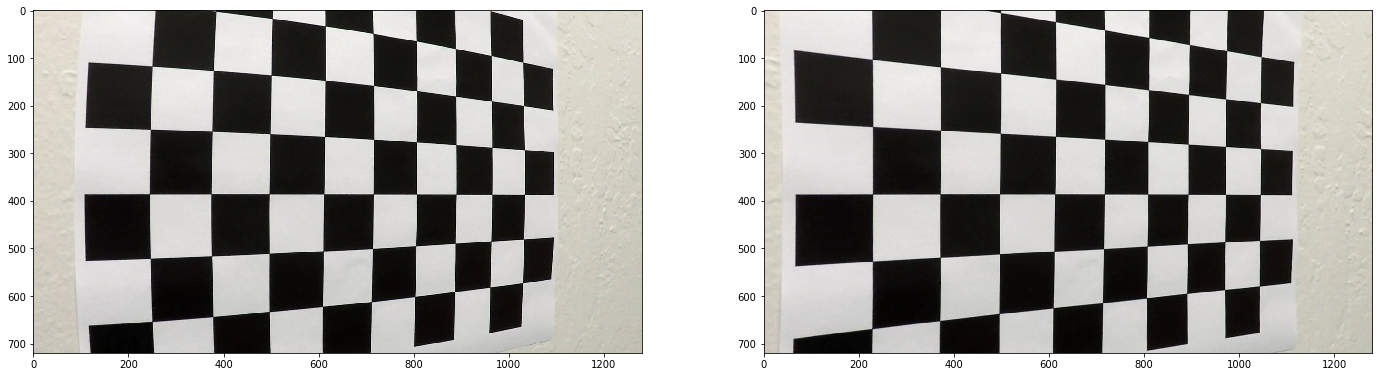

In [201]:
img = mpimg.imread(images[0])
dst = undistort(img, objpoints, imgpoints)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(dst)
cv2.imwrite( "./output_images/chessboard_distorted.png", img )
cv2.imwrite( "./output_images/chessboard_ungdistorted.png", dst )

## Color / Gradient Threshold

#### X-Y Gradient 

In [202]:
def sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0)
    else:
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude 
            # is > thresh_min and < thresh_max
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sbinary

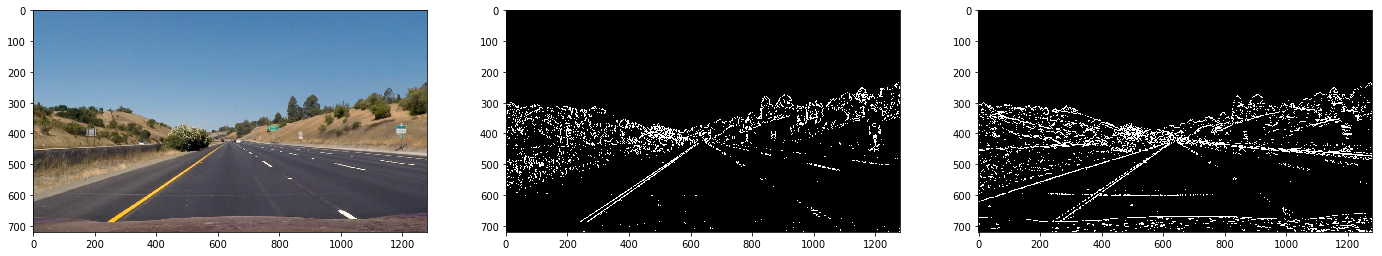

In [203]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
sobelx = sobel_thresh(img, orient='x', thresh_min=20, thresh_max=100)
sobely = sobel_thresh(img, orient='y', thresh_min=20, thresh_max=100)
# # Combine the two binary thresholds
# combined_binary = np.zeros_like(sobelx)
# combined_binary[(sobelx == 1) | (sobely == 1)] = 1


# f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 9))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(sobelx, cmap='gray')
ax3.imshow(sobely, cmap='gray')
# ax4.imshow(combined_binary, cmap='gray')

#### Gradient Magnitude

In [204]:
def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Calculate the magnitude 
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Scale to 8-bit (0 - 255) and convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a binary mask where mag thresholds are met
    sbinary = np.zeros_like(scaled_sobel)
    sbinary[(scaled_sobel >= mag_thresh[0]) & (scaled_sobel <= mag_thresh[1])] = 1
    
    # sybinary = np.zeros_like(scaled_sobely)
    # sybinary[(scaled_sobely >= thresh_min) & (scaled_sobely <= thresh_max)] = 1
    # # 6) Return this mask as your binary_output image
    # binary_output = np.copy(img) # Remove this line
    return sbinary

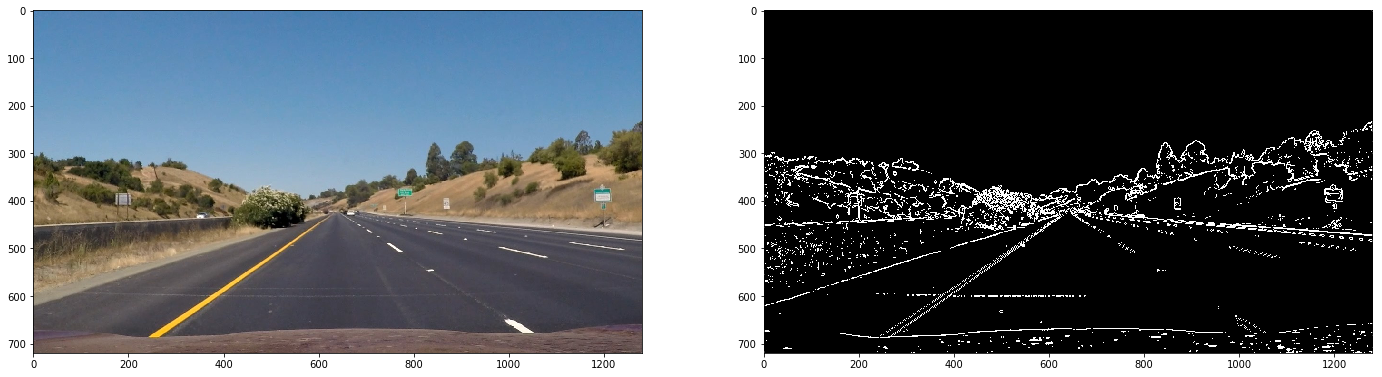

In [205]:
magnitude = mag_thresh(img, sobel_kernel=3, mag_thresh=(30, 100))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(magnitude, cmap='gray')


#### Gradient Direction

In [206]:
def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the gradient in x and y separately
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the x and y gradients
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    #abs_sobel = np.sqrt(np.square(sobelx) + np.square(sobely))
    # 4) Use np.arctan2(abs_sobely, abs_sobelx) to calculate the direction of the gradient 
    dir_grad = np.arctan2(abs_sobely, abs_sobelx)
    # 5) Create a binary mask where direction thresholds are met
    #scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    sbinary = np.zeros_like(dir_grad)
    sbinary[(dir_grad >= thresh[0]) & (dir_grad <= thresh[1])] = 1
    # 6) Return this mask as your binary_output image
    #binary_output = np.copy(img) # Remove this line
    return sbinary

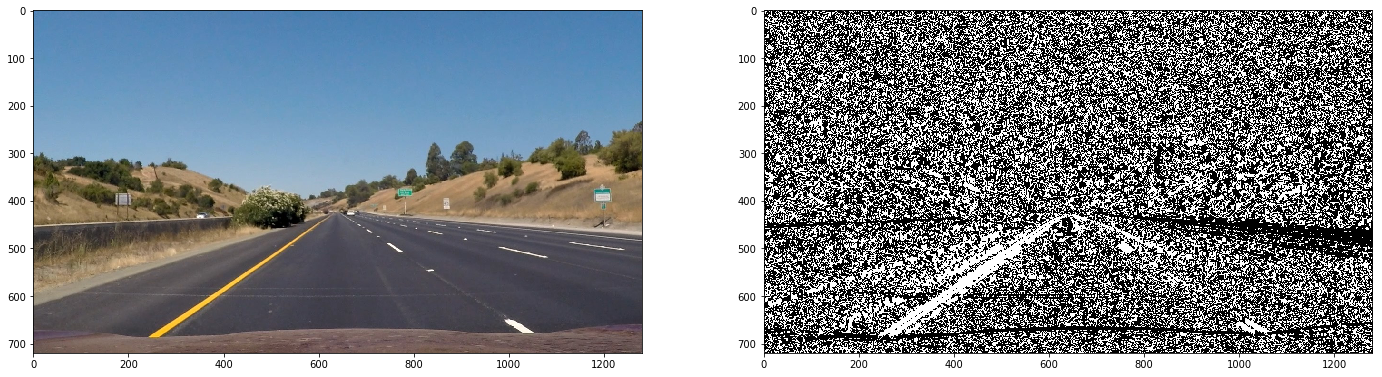

In [207]:
grad_direction = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(grad_direction, cmap='gray')

In [208]:
def hls_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls[:,:,2]
    # 2) Apply a threshold to the S channel
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    # 3) Return a binary image of threshold result
    #binary_output = np.copy(img) # placeholder line
    return binary

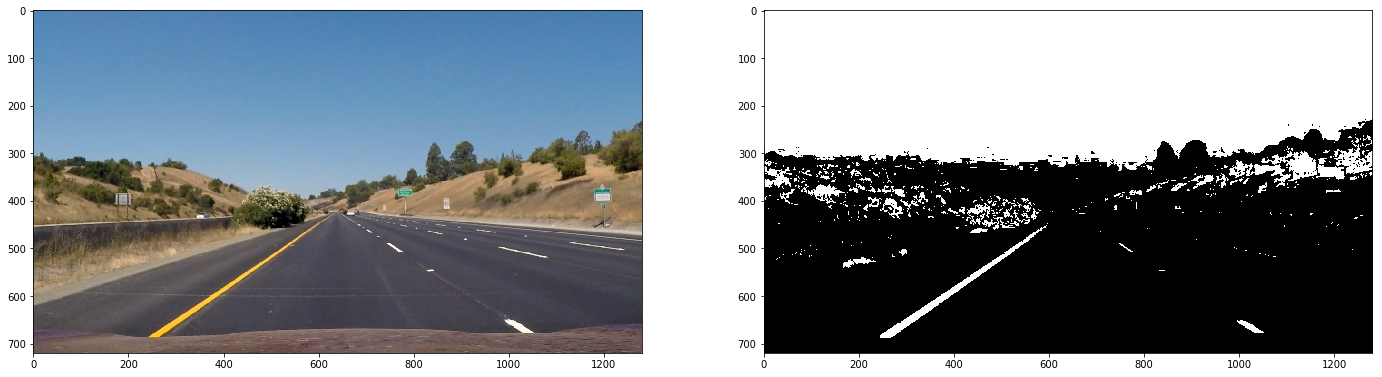

In [209]:
hls_img = hls_select(img, thresh=(90, 255))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(hls_img, cmap='gray')

#### Pipeline

In [210]:
# Edit this function to create your own pipeline.
def mask_image(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    # Sobel x
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    # Stack each channel
    color_binary = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    
    # Combine the two binary thresholds
    combined_binary = np.zeros_like(sxbinary)
    combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
    
    return color_binary, combined_binary

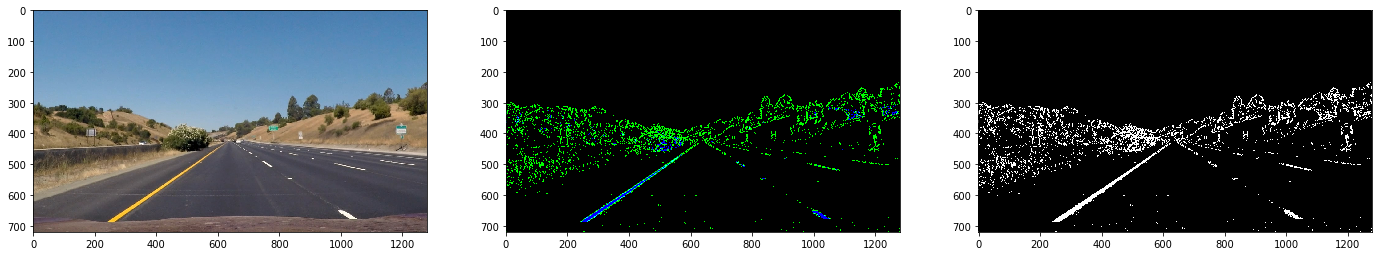

In [211]:
color_binary, combined_binary = mask_image(img)
# Combine the two binary thresholds
# grad_direction = dir_threshold(img, sobel_kernel=15, thresh=(0.7, 1.3))
# combined_binary = np.zeros_like(sobelx)
# combined_binary[(result[:,:,2] == 1) | (sobelx == 1)] = 1

#f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(24, 9))
ax1.imshow(img)
ax2.imshow(color_binary)
ax3.imshow(combined_binary, cmap='gray')


In [229]:
def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

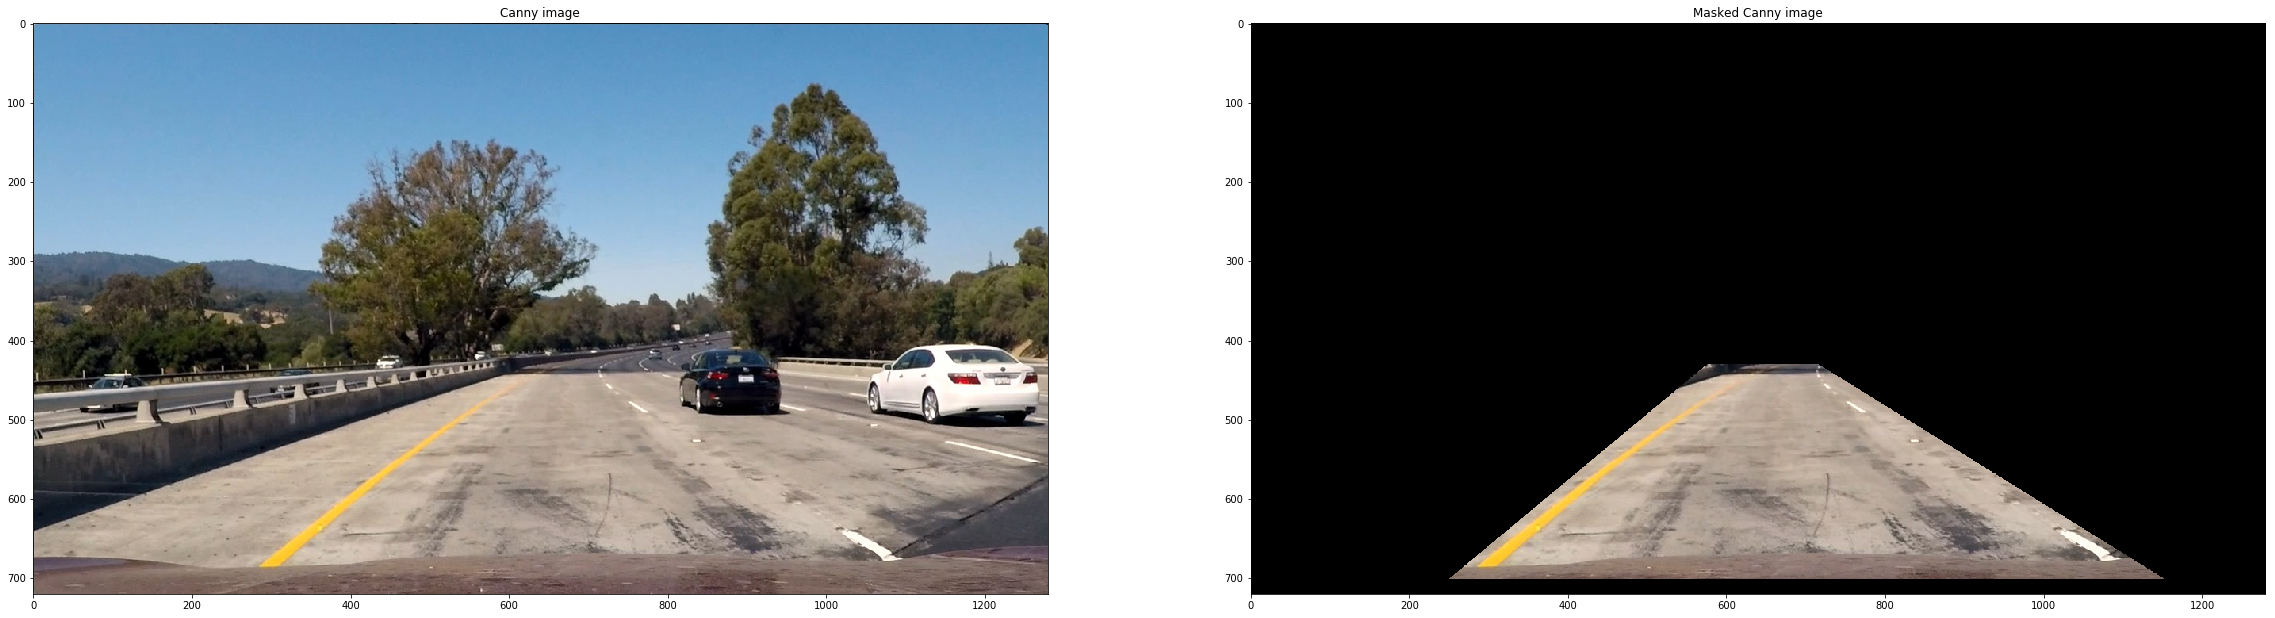

In [252]:
img = mpimg.imread('./test_images/test1.jpg')
vertices = np.array([[(250,700),(1150, 700), (715, 430), (575, 430)]], dtype=np.int32) 

masked_edges = region_of_interest(img, vertices)
# Plot image progression
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,40))
ax1.set_title('Canny image')
ax1.imshow(img)
ax2.set_title('Masked Canny image')
ax2.imshow(masked_edges)

##### Perspective Transform

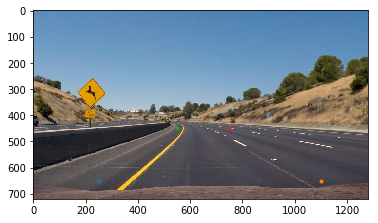

In [214]:
img = mpimg.imread('./test_images/test2.jpg')
#img = mpimg.imread('./test_images/test1.jpg')
plt.imshow(img)
plt.plot(250, 650, '.') # bottom left
plt.plot(1100, 650, '.') # bottom right
plt.plot(550, 450, '.') # top left
plt.plot(750, 450, '.') # top right

In [215]:
def warp(img):
    # Define calibration box and destination box
    img_size = (img.shape[1], img.shape[0])
    
    # Four source coordinate points
    src = np.float32(
    [[300, 650], # bottom left
     [1000, 650], # bottom right
     [600, 447], # top left
     [680, 447]]) # top right
    
    dst = np.float32(
        [[375, 720],
         [1000, 720],
         [375, 0],
         [1000, 0]])
     
    # Compute perspective transform
    M = cv2.getPerspectiveTransform(src, dst)
    
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    # Create warped image, use linear interpolation
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    
    return warped, M, Minv


True

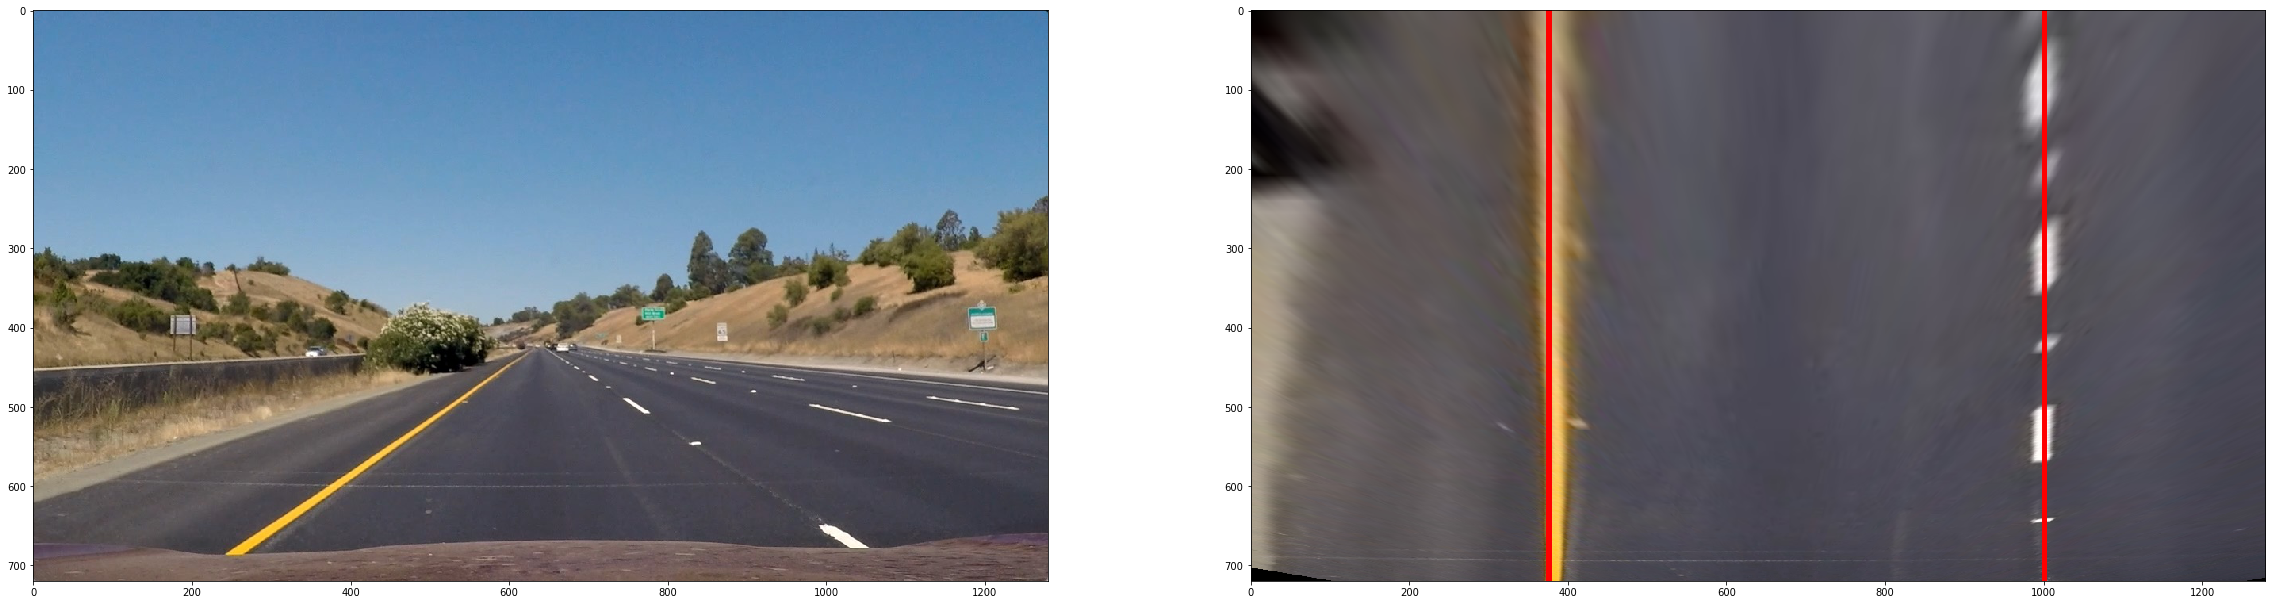

In [269]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
#img = mpimg.imread('./test_images/test1.jpg')
# plt.imshow(img)
# plt.plot(250, 650, '.') # bottom left
# plt.plot(1100, 650, '.') # bottom right
# plt.plot(550, 450, '.') # top left
# plt.plot(750, 450, '.') # top right
# cv2.line(img,(300,650),(600,447),(255,0,0),5)
# cv2.line(img,(1000,650),(690,447),(255,0,0),5)
# undistort image
undist = undistort(img, objpoints, imgpoints)
# color thresh (yellow and white)
combined_binary = color_thresh(undist)
# perspective transform (bird's eye view)
binary_warped, M, Minv = warp(img)
cv2.line(binary_warped,(375,720),(375,0),(255,0,0),5)
cv2.line(binary_warped,(1000,720),(1000,0),(255,0,0),5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,40))
ax1.imshow(img)
ax2.imshow(binary_warped)
#cv2.imwrite( "./output_images/before_perspective.png",  cv2.cvtColor(img, cv2.COLOR_RGB2BGR) )
cv2.imwrite( "./output_images/after_perspective.png", cv2.cvtColor(binary_warped, cv2.COLOR_RGB2BGR))


In [273]:

def pipeline(img):

    # undistort image
    undist = undistort(img, objpoints, imgpoints)
    
    #region of interest mask
   # vertices = np.array([[(150,700),(1150, 700), (850, 500), (450, 500)]], dtype=np.int32)
#     vertices = np.array([[(250,700),(1150, 700), (715, 430), (575, 430)]], dtype=np.int32)
#     region = region_of_interest(undist, vertices)
    
    # binary mask (sobelx and s channel)
    #result, combined_binary = mask_image(undist)
    
    # color thresh (yellow and white)
    combined_binary = color_thresh(undist)
    
    # perspective transform (bird's eye view)
    binary_warped, M, Minv = warp(combined_binary)
    
    # finding lines - sliding windows 
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    

    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]


    # Create an image to draw the lines on
    warped = binary_warped
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (img.shape[1], img.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
#     plt.imshow(result)

    y_eval = 720
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700
    
    left_curverad = ((1 + (2*left_fit[0]*y_eval + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    
#     A = xm_per_pix / (ym_per_pix ** 2) * left_fit[0]
#     B = (xm_per_pix/ym_per_pix) * left_fit[1]
#     left_curverad = ((1 + (2*A*y_eval + B)**2)**1.5) / np.absolute(2*A)
#     right_curverad = ((1 + (2*A*y_eval + B)**2)**1.5) / np.absolute(2*A)
     
    # Find the position of the car from the center

    img_center = 1280/2
    center = (leftx[0] + rightx[0])/2
    
    # Define conversions in x and y from pixels space to meters,
    # assume the lane is about 30 meters long and 3.7 meters wide
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    position = (img_center - center)*xm_per_pix
    #print(leftx[0], rightx[0], center, position)

   
    result = add_curvature_data(result, left_curverad, position)
    
    
    
    return result

True

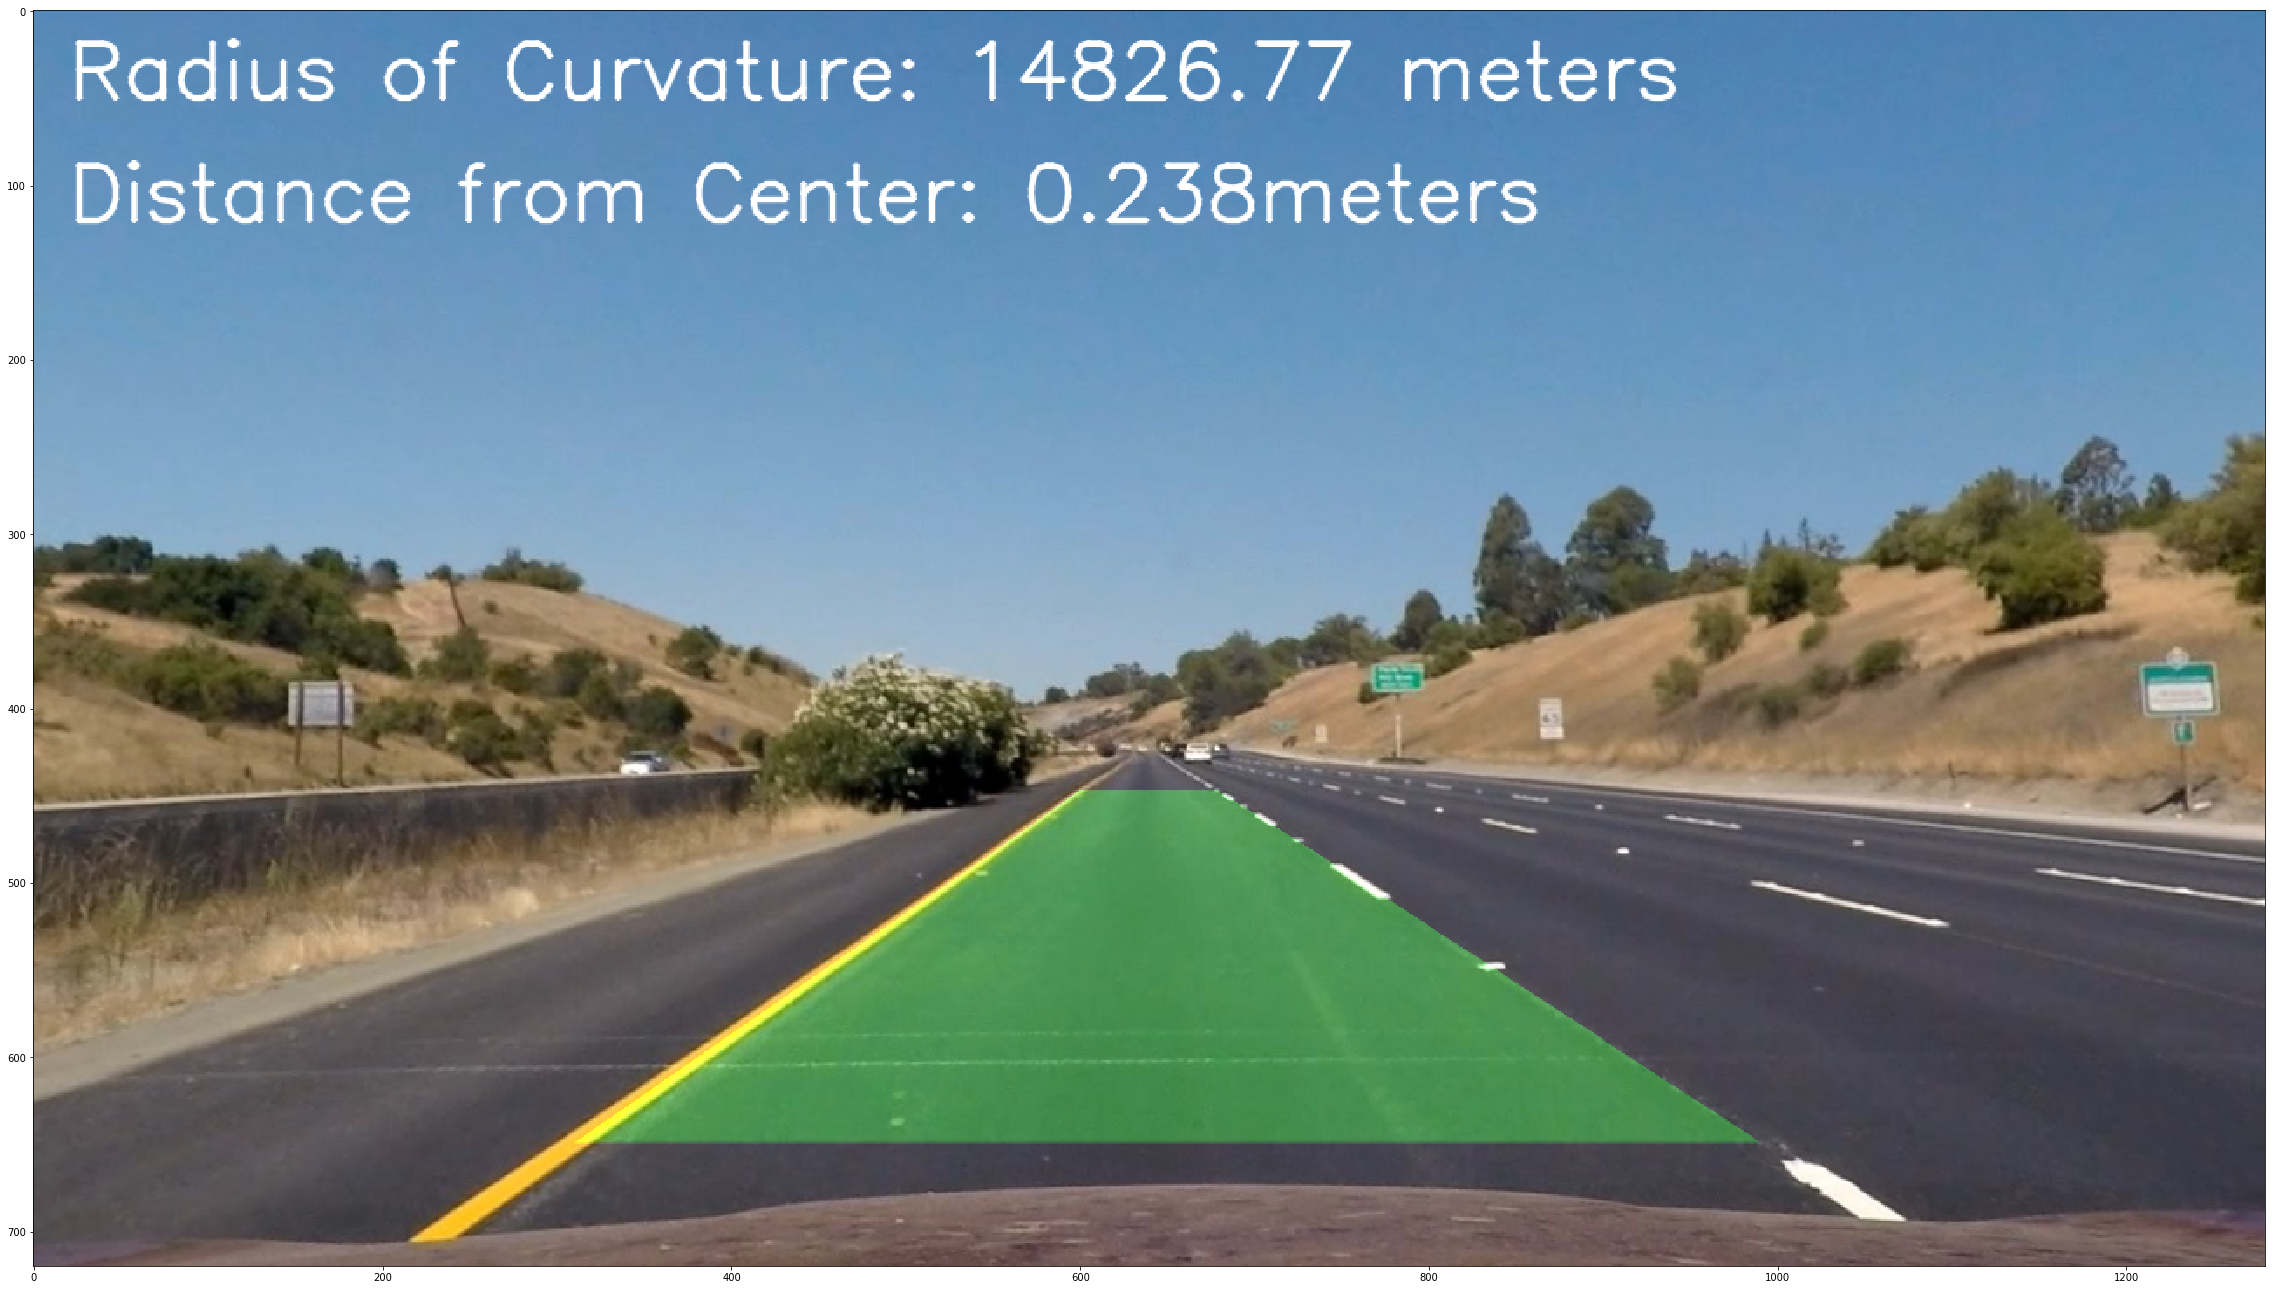

In [272]:
img = mpimg.imread('./test_images/straight_lines1.jpg') 
result = pipeline(img)

f, (ax1) = plt.subplots(1, 1, figsize=(40,40))
ax1.imshow(result)
cv2.imwrite( "./output_images/pipeline_out.png", cv2.cvtColor(result, cv2.COLOR_RGB2BGR) )

## Detect Lane Lines

In [217]:
def sliding_window(binary_warped):
    # Assuming you have created a warped binary image called "binary_warped"
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # Choose the number of sliding windows
    nwindows = 9
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Set the width of the windows +/- margin
    margin = 100
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),
        (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),
        (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds] 

    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]

    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
#     plt.imshow(out_img)
#     plt.plot(left_fitx, ploty, color='yellow')
#     plt.plot(right_fitx, ploty, color='yellow')
#     plt.xlim(0, 1280)
#     plt.ylim(720, 0)
    return out_img

True

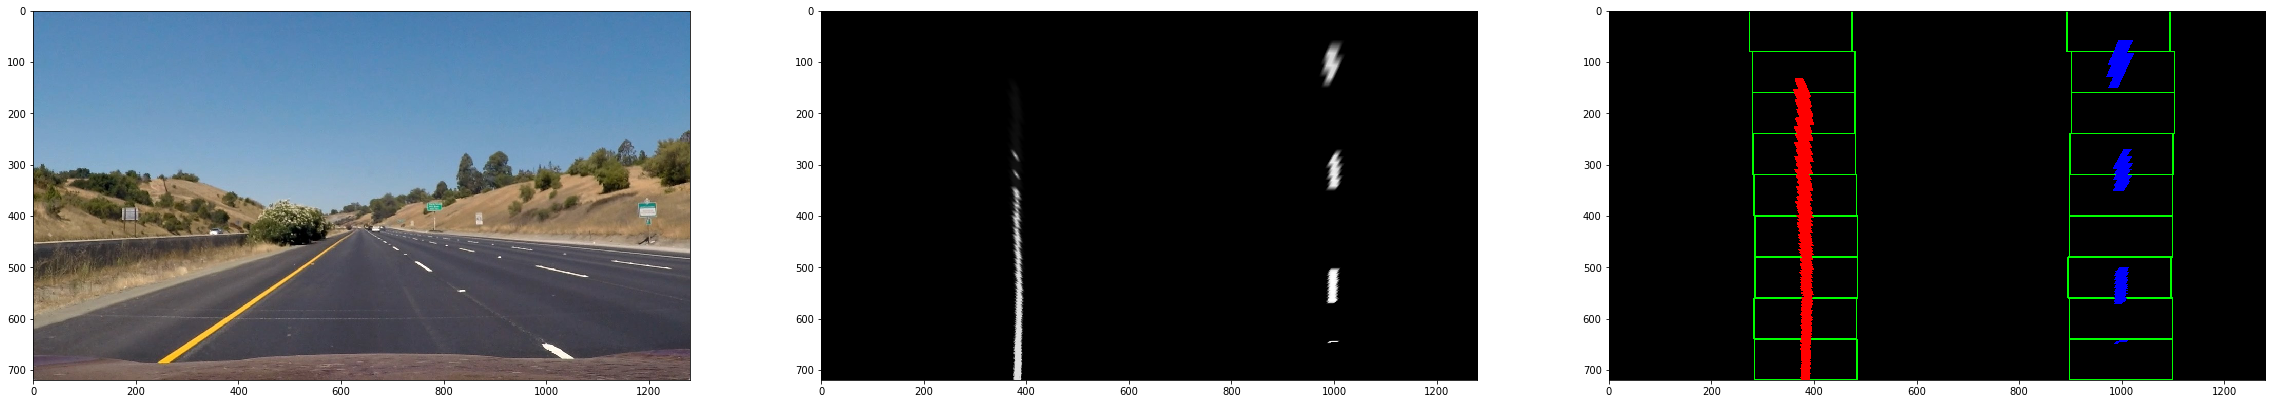

In [271]:
img = mpimg.imread('./test_images/straight_lines1.jpg')
# undistort image
undist = undistort(img, objpoints, imgpoints)
    
# binary mask (sobelx and s channel)
result = color_thresh(undist)

# perspective transform (bird's eye view)
binary_warped, M, Minv = warp(result)

windowed = sliding_window(binary_warped)


f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(40,40))
ax1.imshow(img)
ax2.imshow(binary_warped, cmap='gray')
ax3.imshow(windowed)
cv2.imwrite( "./output_images/sliding0.png", cv2.cvtColor(img, cv2.COLOR_RGB2BGR))
cv2.imwrite( "./output_images/sliding2.png", binary_warped )
cv2.imwrite( "./output_images/sliding3.png", windowed )


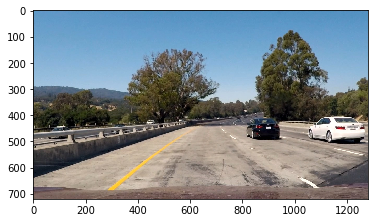

In [219]:
img = mpimg.imread('./test_images/test1.jpg')

# undistort image
undist = undistort(img, objpoints, imgpoints)
    
# binary mask (sobelx and s channel)
result, combined_binary = mask_image(undist)
#plt.imshow(combined_binary, cmap='gray')

# # perspective transform (bird's eye view)
# binary_warped, M, Minv = warp(combined_binary)

plt.imshow(img)

In [220]:
def color_thresh(img):
    
    #vertices = np.array([[(150,700),(1150, 700), (850, 400), (450, 400)]], dtype=np.int32)
    vertices = np.array([[(250,700),(1150, 700), (735, 400), (550, 400)]], dtype=np.int32) 
    img = region_of_interest(img, vertices)
    
    #  RGB Yellow thresholding
    lower_yellow = np.array([190,190,0], dtype = "uint8")
    upper_yellow = np.array([255,255,150], dtype = "uint8")
    
    mask = cv2.inRange(img, lower_yellow, upper_yellow)
    mask_yellow = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    yellow_img = img & mask_yellow
    #yellow_binary =  yellow_img[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    yellow_binary = cv2.cvtColor(yellow_img, cv2.COLOR_RGB2GRAY)
    
    
    # RGB White
    lower_white = np.array([195,200,200], dtype = "uint8")
    upper_white = np.array([255,255,255], dtype = "uint8")
    
    mask = cv2.inRange(img, lower_white, upper_white)
    mask_white = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    white_img = img & mask_white
    white_binary = cv2.cvtColor(white_img, cv2.COLOR_RGB2GRAY)
    
#     # 
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     lower_yellow_hsv = np.array([40,50,50], dtype = "uint8")
#     upper_yellow_hsv = np.array([60,255,255], dtype = "uint8") 

    hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
   
    lower_white_hsv = np.array([0,150,100], dtype = "uint8")
    upper_white_hsv = np.array([100,255,255], dtype = "uint8")
#     print(l.shape)
#     print(lower_white_hls.shape)
    mask = cv2.inRange(hsv, lower_white_hsv, upper_white_hsv)
    mask_white_hsv = cv2.cvtColor(mask, cv2.COLOR_GRAY2RGB)
    mask_white_hsv = cv2.cvtColor(mask_white_hsv, cv2.COLOR_RGB2HSV)
    white_img_hsv = hsv & mask_white_hsv
    white_img_hsv_binary = cv2.cvtColor(white_img_hsv, cv2.COLOR_HSV2RGB)
    white_img_hsv_binary = cv2.cvtColor(white_img_hsv, cv2.COLOR_RGB2GRAY)
    #white_binary_hls = white_img_hsv[:,:,2]#cv2.cvtColor(white_img, cv2.COLOR_RGB2GRAY)
    
    
#     hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
#     lower_white_hsv = np.array([0,0,210], dtype = "uint8")
#     upper_white_hsv = np.array([40,40,255], dtype = "uint8")
#     mask = cv2.inRange(hsv, lower_white_hsv, upper_white_hsv)
#     mask_white_hsv = cv2.cvtColor(mask, cv2.COLOR_GRAY2HSV)
#     white_img_hsv = hsv & mask_white_hsv
#     white_binary_hsv = white_img_hsv[:,:,2]#cv2.cvtColor(white_img, cv2.COLOR_RGB2GRAY)
    
    
    
    
#     img = yellow_binary | white_binary
    #img = yellow_binary | white_binary 
    result = np.zeros_like(white_img_hsv_binary)
    #result = white_img_hsv_binary
    result = yellow_binary | white_img_hsv_binary | white_binary#white_img_hsv
    
    return result

True

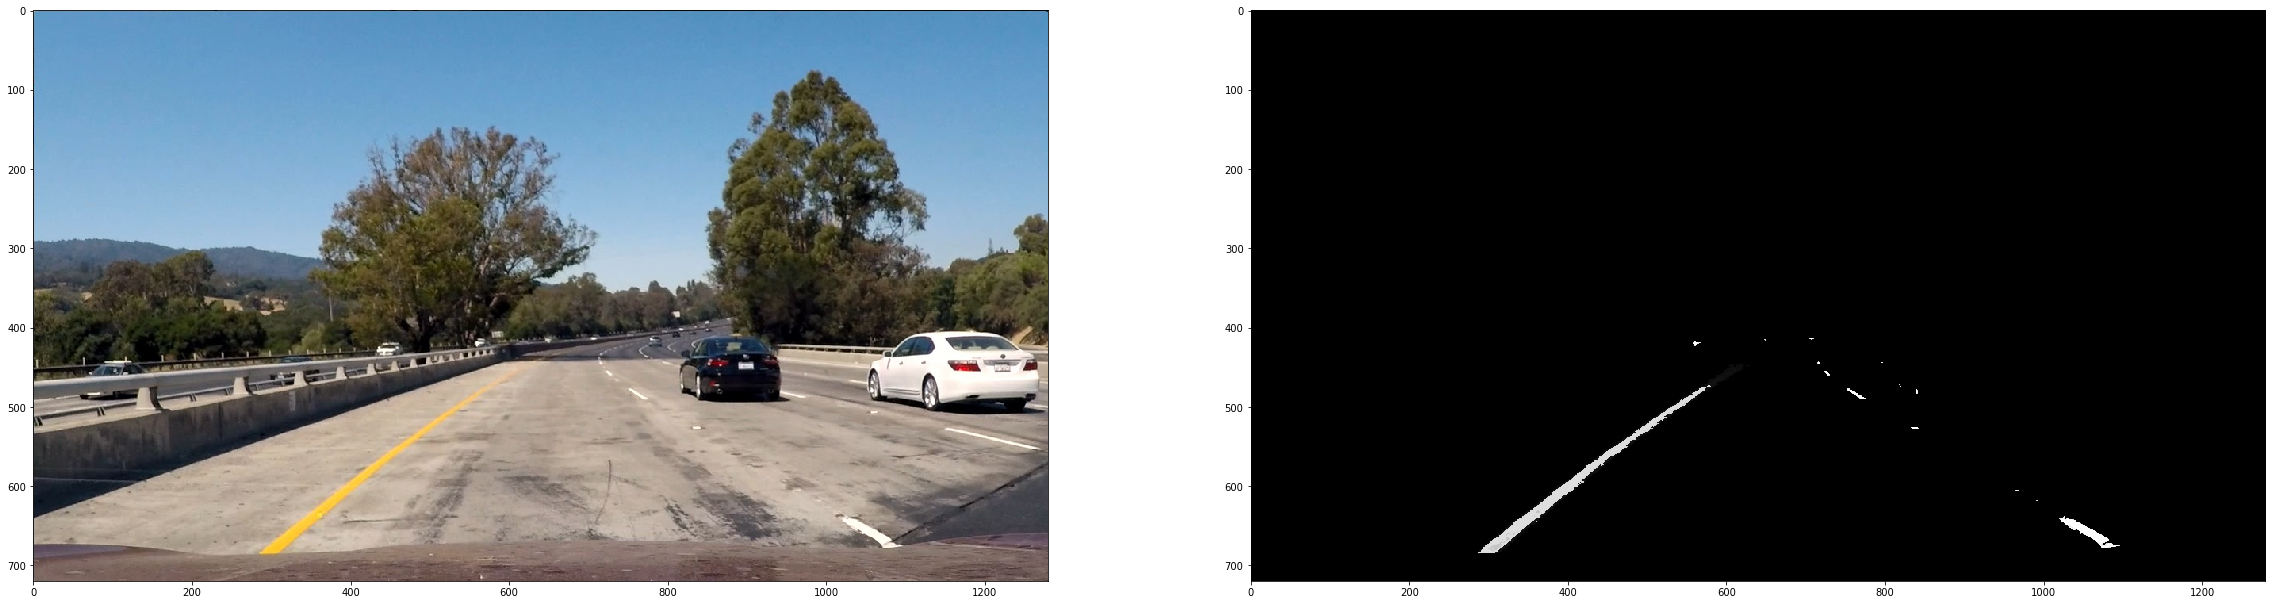

In [261]:
img = mpimg.imread('./test_images/test1.jpg')
out = color_thresh(img)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(40,40))
ax1.imshow(img)
ax2.imshow(out, cmap='gray')
cv2.imwrite( "./output_images/unmasked.png",  cv2.cvtColor(img, cv2.COLOR_RGB2BGR) )
cv2.imwrite( "./output_images/masked.png", out )
#plt.imshow(result)

###### 

In [222]:
def add_curvature_data(img, radius, center_dist):
    img_copy = np.copy(img)
    text = 'Radius of Curvature: ' + '{:04.2f}'.format(radius) + ' meters'
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(img_copy,text,(20,50), font, 1.5,(255,255,255),2,cv2.LINE_AA)
#     direction = ''
#     if center_dist > 0:
#         direction = 'right'
#     elif center_dist < 0:
#         direction = 'left'
    abs_center_dist = abs(center_dist)
    text = 'Distance from Center: {:04.3f}'.format(abs_center_dist) + 'meters'
    cv2.putText(img_copy, text, (20,120), font, 1.5, (255,255,255), 2, cv2.LINE_AA)
    return img_copy

## Determine Lane Curvature

In [25]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [ ]:
project_output = 'project_video_output_better3.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip('project_video.mp4')
white_clip = clip1.fl_image(pipeline)#NOTE: this function expects color images!!
%time white_clip.write_videofile(project_output, audio=False)

In [ ]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(project_output))